In [2]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd/fangming/CEMBA/scripts/ClusterCrossValidation')
import importlib


from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
from sklearn.model_selection import KFold
import pickle

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import cluster_cv_utils
importlib.reload(cluster_cv_utils)
from cluster_cv_utils import *


# Configs  

In [3]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/17/2019 05:41:18 PM *


In [4]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_neurons_v6'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [19]:
# ps = np.linspace(0.1, 1, 10)[::-1]
ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 0.25, 0.75, 0.01, 0.02, 0.05]
ps = np.sort(ps)
mods_selected = [
    'snmcseq_gene',
    'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
    '10x_cells', 
    '10x_nuclei', 
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_Macosko',
    ]
resolutions = [0.5, 1, 2, 3, 4, 6, 8, 12, 16, 20, 30, 40, 60, 80, 100]
logging.info(ps)
logging.info(' '.join(mods_selected))

07/18/2019 09:29:24 AM [0.01 0.02 0.05 0.1  0.2  0.25 0.3  0.4  0.5  0.6  0.7  0.75 0.8  0.9
 1.  ]
07/18/2019 09:29:24 AM snmcseq_gene snatac_gene smarter_cells smarter_nuclei 10x_cells 10x_nuclei 10x_cells_v3 10x_nuclei_v3 10x_nuclei_v3_Macosko


07/18/2019 09:29:26 AM 0.01
07/18/2019 09:29:26 AM 10x_cells
07/18/2019 09:29:26 AM 0.01
07/18/2019 09:29:26 AM 10x_nuclei
07/18/2019 09:29:26 AM 0.01
07/18/2019 09:29:26 AM 10x_cells_v3
07/18/2019 09:29:26 AM 0.01
07/18/2019 09:29:26 AM 10x_nuclei_v3
07/18/2019 09:29:26 AM 0.01
07/18/2019 09:29:26 AM 10x_nuclei_v3_Macosko
07/18/2019 09:29:26 AM 0.02
07/18/2019 09:29:26 AM 10x_cells
07/18/2019 09:29:27 AM 0.02
07/18/2019 09:29:27 AM 10x_nuclei
07/18/2019 09:29:27 AM 0.02
07/18/2019 09:29:27 AM 10x_cells_v3
07/18/2019 09:29:27 AM 0.02
07/18/2019 09:29:27 AM 10x_nuclei_v3
07/18/2019 09:29:27 AM 0.02
07/18/2019 09:29:27 AM 10x_nuclei_v3_Macosko
07/18/2019 09:29:27 AM 0.05
07/18/2019 09:29:27 AM 10x_cells
07/18/2019 09:29:27 AM 0.05
07/18/2019 09:29:27 AM 10x_nuclei
07/18/2019 09:29:28 AM 0.05
07/18/2019 09:29:28 AM 10x_cells_v3
07/18/2019 09:29:28 AM 0.05
07/18/2019 09:29:28 AM 10x_nuclei_v3
07/18/2019 09:29:28 AM 0.05
07/18/2019 09:29:28 AM 10x_nuclei_v3_Macosko
07/18/2019 09:29:28 AM 0.

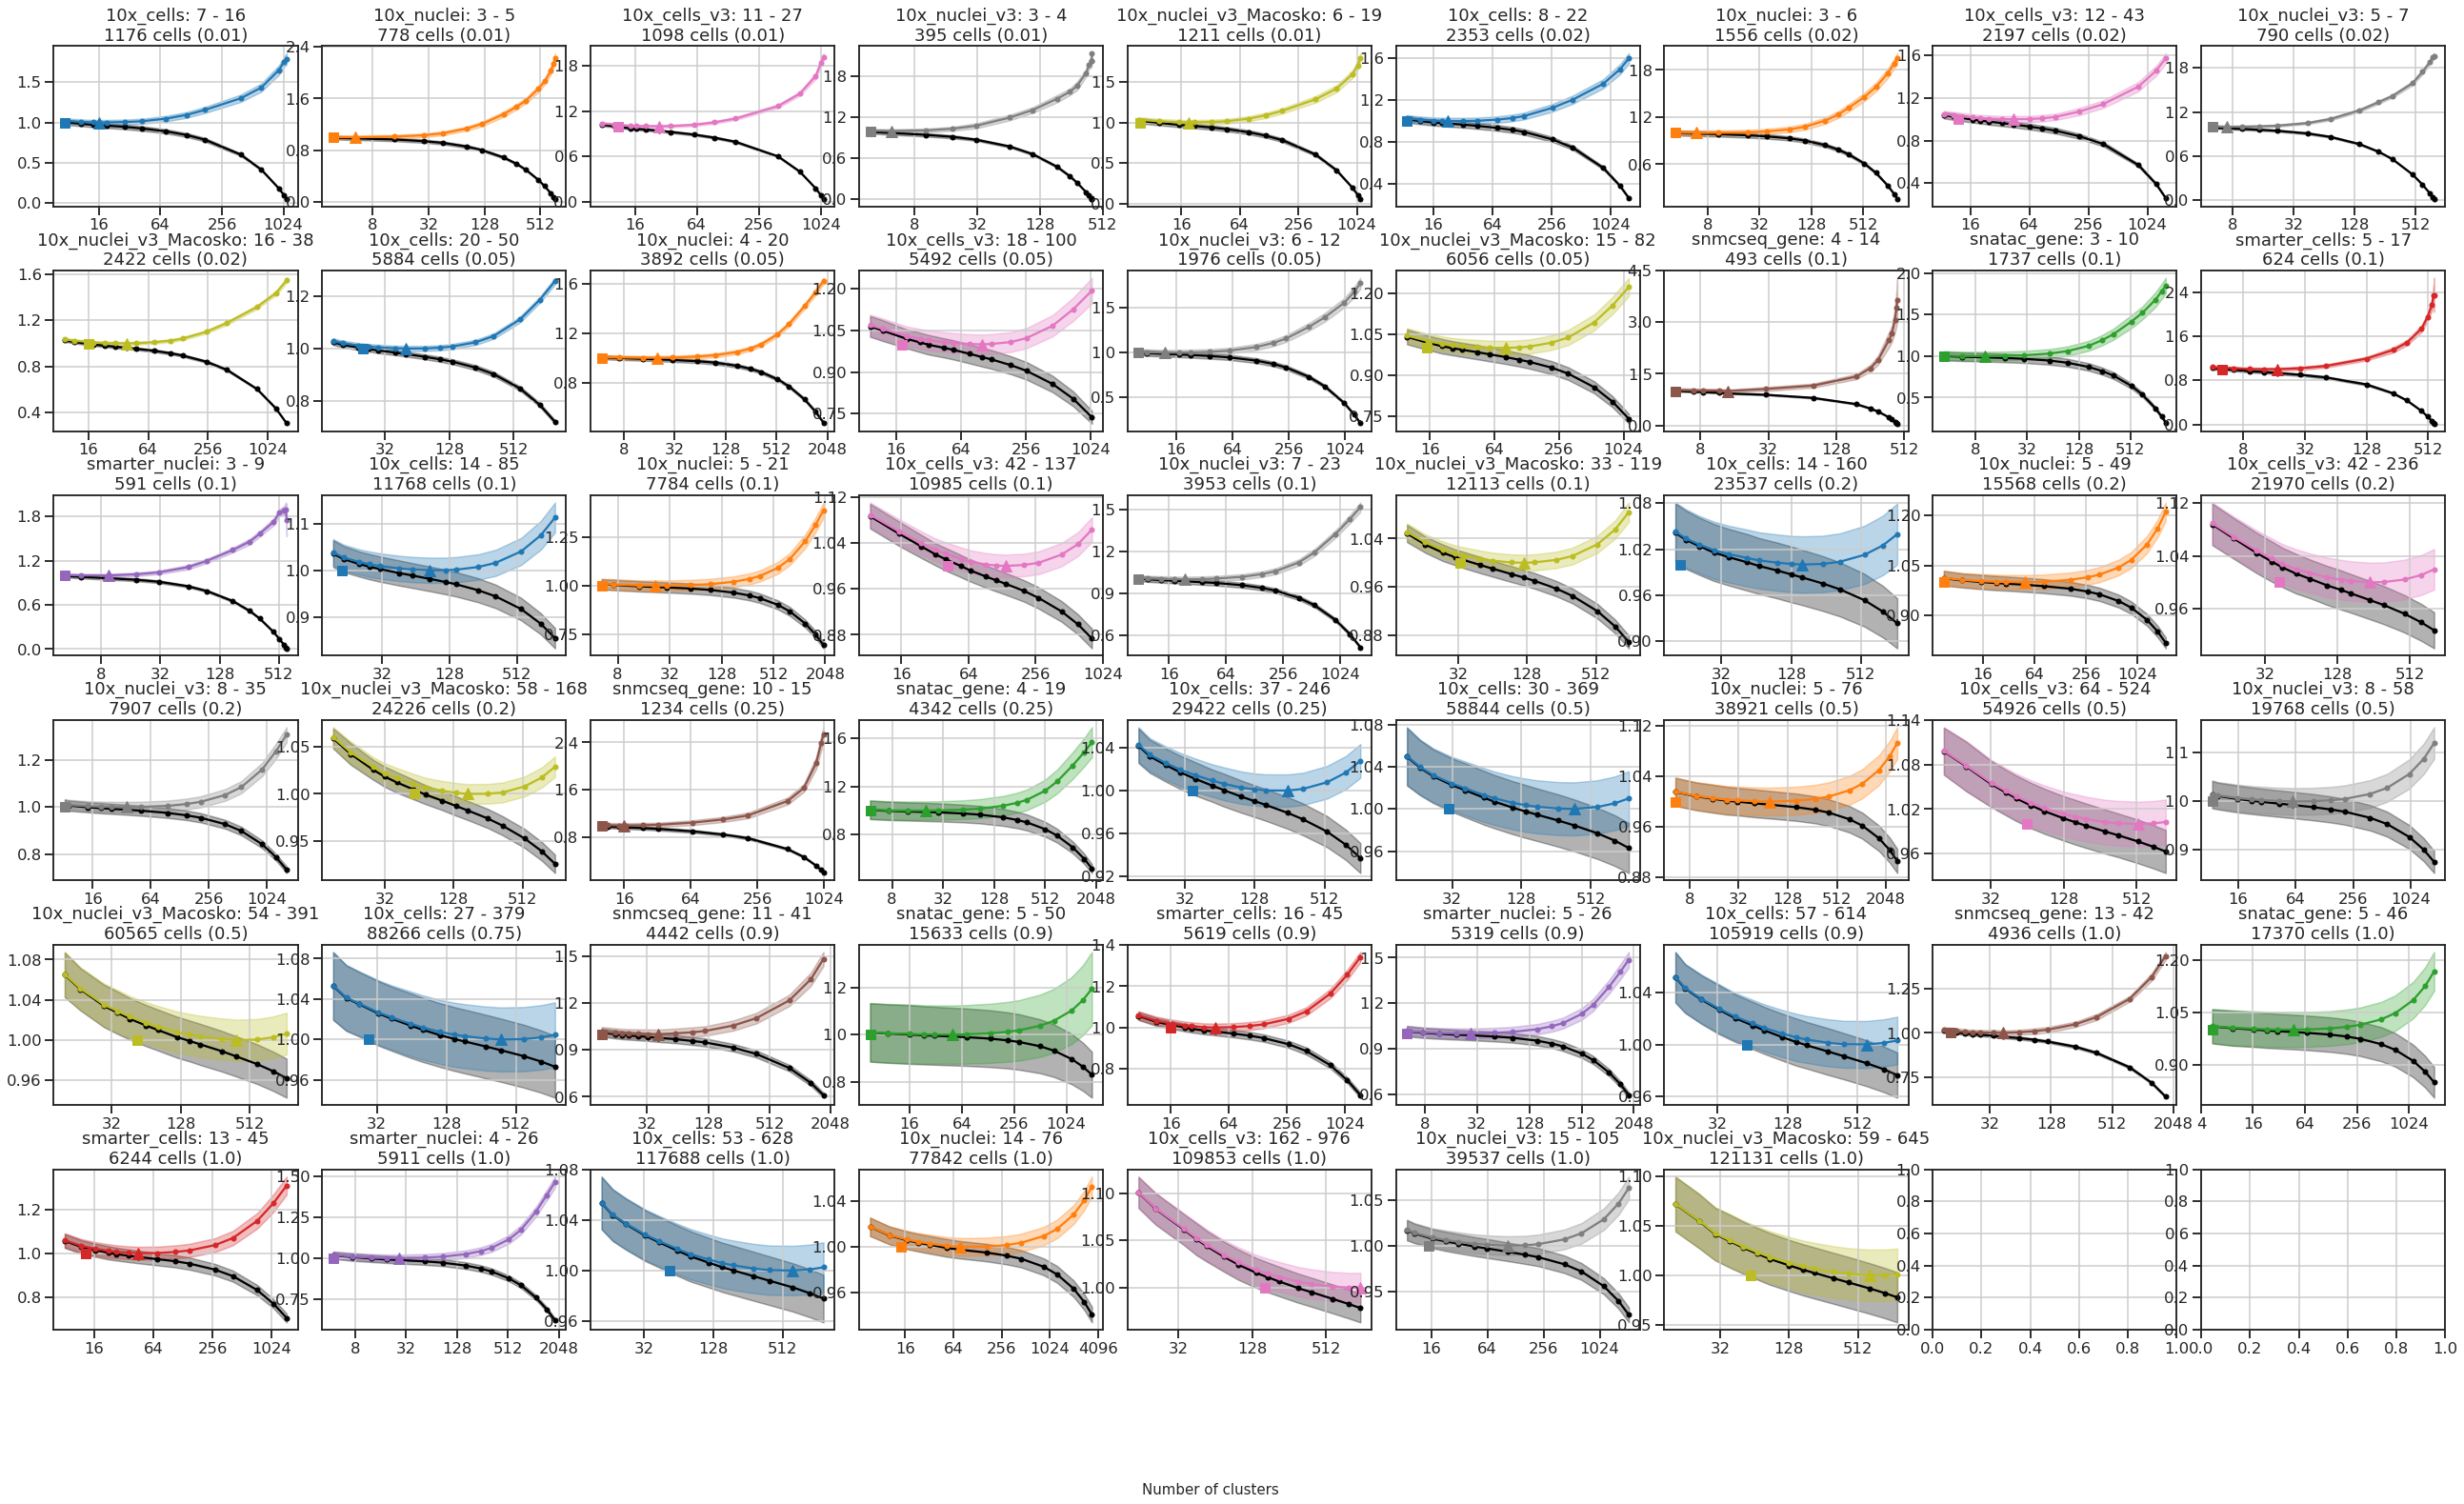

In [20]:
res_sum_sum = []

scale = 1

n = 0
for i, (mod, p) in enumerate(itertools.product(mods_selected, ps)):
    name = 'mop_cv_one_dataset_p{}_{}'.format(int(p*100), mod)
    outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
    output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
    output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
    if not os.path.isfile(output_results):
        continue
    n += 1
    
nx = len(mods_selected)
ny = int((n+nx-1)/nx)
    
fig, axs = plt.subplots(ny, nx, figsize=(5*nx*scale,4*ny*scale))
axs = axs.flatten()

ax_idx = -1 
for i, (p, mod) in enumerate(itertools.product(ps, mods_selected)):
    
    name = 'mop_cv_one_dataset_p{}_{}'.format(int(p*100), mod)
    outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
    output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
    output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
    
    if not os.path.isfile(output_results):
        continue
    ax_idx += 1
        
    logging.info(p)
    logging.info(mod)
    ax = axs[ax_idx]
    
    metadata = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)

    # Getting back the objects:
    with open(output_results, 'rb') as f: 
        (
         res_nclsts, res,
        ) = pickle.load(f)

    res_nclsts_summary = res_nclsts.groupby('resolution').agg({'nclsts': ['mean', 'std']})
    res_summary = res.groupby(['resolution']).agg({'mse': ['mean', 'std'],
                                                          'mse_t': ['mean', 'std'],
                                                        })

#     output = output_figures.format('cluster_cv_nosharey', 'pdf')
    n_folds = 5
    x = res_nclsts_summary['nclsts']['mean'].values
    ys = res_summary #.xs(mod, level='mod')
    base_level = np.min(ys['mse']['mean'].values)
    y, y_err = ys['mse']['mean'].values/base_level, (ys['mse']['std'].values/np.sqrt(n_folds))/base_level, 
    yt, yt_err = ys['mse_t']['mean'].values/base_level, (ys['mse_t']['std'].values/np.sqrt(n_folds))/base_level, 
    
    if i == 0:
        ylabel = 'MSE +/- SEM\n(normalized)'
    else: 
        ylabel = ''
    xlabel = ''
    min_x_se, min_x, min_y = plot_bi_cv_subfig(ax, x, 
                                              y, y_err,
                                              yt, yt_err,
                                              settings[mod].color, mod, 
                                              xlabel=xlabel,
                                              ylabel=ylabel
                                             )
    ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
    ax.set_title(ax.get_title()+'\n{} cells ({})'.format(int(len(metadata)*p), p))
    # end for
    
    res_sum_sum.append({'mod': mod,
                        'p': p,
                        'n_cell': int(len(metadata)*p),
                        'n_clst_min': min_x,  
                        'n_clst_1se': min_x_se, 
                       })
res_sum_sum = pd.DataFrame(res_sum_sum)

fig.subplots_adjust(hspace=0.4, wspace=0.1, bottom=0.1)
fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
#     fig.savefig(output, bbox_inches='tight')
plt.show()

In [21]:
res_sum_sum

,mod,n_cell,n_clst_1se,n_clst_min,p
0,10x_cells,1176,7,16,0.01
1,10x_nuclei,778,3,5,0.01
2,10x_cells_v3,1098,11,27,0.01
3,10x_nuclei_v3,395,3,4,0.01
4,10x_nuclei_v3_Macosko,1211,6,19,0.01
5,10x_cells,2353,8,22,0.02
6,10x_nuclei,1556,3,6,0.02
7,10x_cells_v3,2197,12,43,0.02
8,10x_nuclei_v3,790,5,7,0.02
9,10x_nuclei_v3_Macosko,2422,16,38,0.02


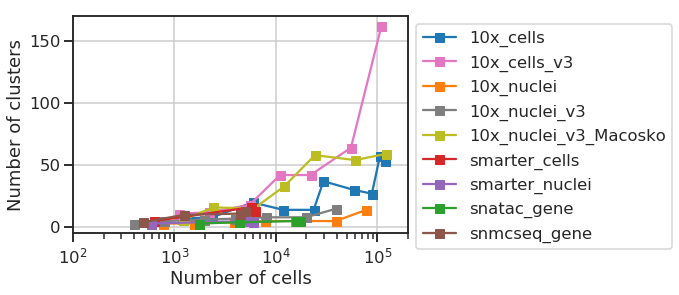

In [28]:
fig, ax = plt.subplots()
for mod, df_sub in res_sum_sum.groupby('mod'):
    df_sub = df_sub.sort_values('n_cell')
    x = df_sub['n_cell'].values
    y = df_sub['n_clst_1se'].values
    c = settings[mod].color 
    ax.plot(x, y, '-s', color=c, label=mod)
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log', basex=10)
# ax.set_yscale('log', basey=2)
ax.set_xlabel('Number of cells')
ax.set_ylabel('Number of clusters')
# ax.set_ylim([0, 60])
ax.set_xlim([1e2, 2e5])

plt.show()

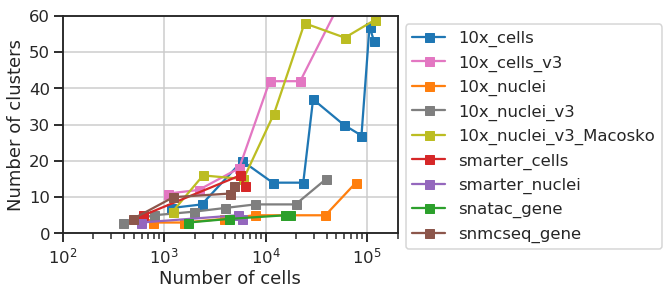

In [29]:
fig, ax = plt.subplots()
for mod, df_sub in res_sum_sum.groupby('mod'):
    df_sub = df_sub.sort_values('n_cell')
    x = df_sub['n_cell'].values
    y = df_sub['n_clst_1se'].values
    c = settings[mod].color 
    ax.plot(x, y, '-s', color=c, label=mod)
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log', basex=10)
ax.set_xlabel('Number of cells')
ax.set_ylabel('Number of clusters')
ax.set_ylim([0, 60])
ax.set_xlim([1e2, 2e5])

plt.show()

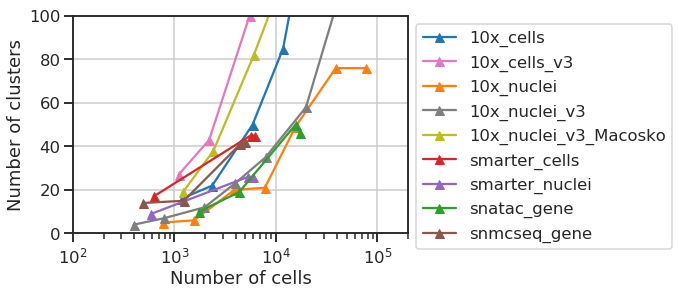

In [30]:
fig, ax = plt.subplots()
for mod, df_sub in res_sum_sum.groupby('mod'):
    df_sub = df_sub.sort_values('n_cell')
    x = df_sub['n_cell'].values
    y = df_sub['n_clst_min'].values
    c = settings[mod].color 
    ax.plot(x, y, '-^', color=c, label=mod)
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log', basex=10)
ax.set_xlabel('Number of cells')
ax.set_ylabel('Number of clusters')
ax.set_ylim([0, 100])
ax.set_xlim([1e2, 2e5])
plt.show()
